# Football Data EDA & Cleaning

This notebook performs Exploratory Data Analysis (EDA) and identifies data cleaning methods for downloaded football match data.

## Data Source
- **Source**: football-data.co.uk
- **Location**: `../2_Backend_Football_Probability_Engine/data/1_data_ingestion/`
- **Format**: CSV files organized by batch folders (`batch_{N}_{League_Name}/`)

## Objectives
1. Load and explore downloaded CSV files
2. Identify data quality issues
3. Propose cleaning methods
4. Visualize data distributions
5. Generate cleaning recommendations


In [10]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import glob
import warnings
from datetime import datetime
import json
from collections import Counter

# Try to import seaborn (optional - for enhanced styling)
try:
    import seaborn as sns
    HAS_SEABORN = True
except ImportError:
    HAS_SEABORN = False
    print("⚠️  seaborn not installed. Install with: pip install seaborn")
    print("   Continuing without seaborn (basic matplotlib styling will be used)")

warnings.filterwarnings('ignore')

# Set plotting style
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except OSError:
    try:
        plt.style.use('seaborn-darkgrid')
    except OSError:
        plt.style.use('default')
        print("Using default matplotlib style")

if HAS_SEABORN:
    sns.set_palette("husl")

# Configuration
# Try multiple possible paths to find the data directory
possible_paths = [
    # Absolute path (workspace root)
    Path("F:/[ 11 ] Football Probability Engine  [SP Soccer]/2_Backend_Football_Probability_Engine/data/1_data_ingestion"),
    # Relative from notebook location
    Path("../2_Backend_Football_Probability_Engine/data/1_data_ingestion"),
    # Relative from current working directory
    Path.cwd() / ".." / "2_Backend_Football_Probability_Engine" / "data" / "1_data_ingestion",
    Path.cwd().parent.parent / "2_Backend_Football_Probability_Engine" / "data" / "1_data_ingestion",
    # If notebook is in a subdirectory
    Path("../../2_Backend_Football_Probability_Engine/data/1_data_ingestion"),
]

DATA_DIR = None
for path in possible_paths:
    resolved_path = path.resolve()
    if resolved_path.exists() and resolved_path.is_dir():
        DATA_DIR = resolved_path
        break

if DATA_DIR is None:
    # Fallback: use the first path and let user know
    DATA_DIR = possible_paths[0].resolve()
    print(f"⚠️  Warning: Could not find data directory automatically")
    print(f"   Using: {DATA_DIR}")
    print(f"   Please update DATA_DIR if this is incorrect")
else:
    print(f"✓ Found data directory: {DATA_DIR}")

print(f"\nDirectory exists: {DATA_DIR.exists()}")
if DATA_DIR.exists():
    batch_folders = list(DATA_DIR.glob("batch_*"))
    csv_count = sum(len(list(folder.glob("*.csv"))) for folder in batch_folders if folder.is_dir())
    print(f"✓ Found {len(batch_folders)} batch folders")
    print(f"✓ Found {csv_count} CSV files total")
else:
    print(f"✗ Data directory not found!")
    print(f"   Please check the path above")


✓ Found data directory: F:\[ 11 ] Football Probability Engine  [SP Soccer]\2_Backend_Football_Probability_Engine\data\1_data_ingestion

Directory exists: True
✓ Found 26 batch folders
✓ Found 182 CSV files total


In [11]:
# Find all CSV files in batch folders
def find_all_csv_files(data_dir):
    """Find all CSV files in batch folders"""
    csv_files = []
    if data_dir.exists():
        for batch_folder in data_dir.glob("batch_*"):
            if batch_folder.is_dir():
                for csv_file in batch_folder.glob("*.csv"):
                    csv_files.append({
                        'path': csv_file,
                        'batch_folder': batch_folder.name,
                        'filename': csv_file.name,
                        'league_code': csv_file.stem.split('_')[0] if '_' in csv_file.stem else '',
                        'season': csv_file.stem.split('_')[1] if '_' in csv_file.stem else ''
                    })
    return csv_files

csv_files = find_all_csv_files(DATA_DIR)
print(f"Found {len(csv_files)} CSV files")
print("\nSample files:")
for f in csv_files[:5]:
    print(f"  - {f['batch_folder']}/{f['filename']}")


Found 182 CSV files

Sample files:
  - batch_176_Premier_League/E0_1920.csv
  - batch_176_Premier_League/E0_2021.csv
  - batch_176_Premier_League/E0_2122.csv
  - batch_176_Premier_League/E0_2223.csv
  - batch_176_Premier_League/E0_2324.csv


In [12]:
# Load a sample CSV file to understand structure
def load_csv_file(file_path):
    """Load CSV file with error handling"""
    try:
        # Try different encodings
        for encoding in ['utf-8', 'latin-1', 'iso-8859-1']:
            try:
                df = pd.read_csv(file_path, encoding=encoding)
                return df, encoding
            except UnicodeDecodeError:
                continue
        return None, None
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None, None

if csv_files:
    sample_file = csv_files[0]['path']
    print(f"Loading sample file: {sample_file.name}")
    sample_df, encoding = load_csv_file(sample_file)
    
    if sample_df is not None:
        print(f"✓ Loaded successfully (encoding: {encoding})")
        print(f"Shape: {sample_df.shape}")
        print(f"\nColumns ({len(sample_df.columns)}):")
        print(sample_df.columns.tolist())
        print(f"\nFirst few rows:")
        display(sample_df.head())
    else:
        print("✗ Failed to load sample file")
else:
    print("No CSV files found. Please download data first using the Data Ingestion page.")


Loading sample file: E0_1920.csv
✓ Loaded successfully (encoding: utf-8)
Shape: (380, 106)

Columns (106):
['Div', 'Date', 'Time', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC', 'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD', 'WHA', 'VCH', 'VCD', 'VCA', 'MaxH', 'MaxD', 'MaxA', 'AvgH', 'AvgD', 'AvgA', 'B365>2.5', 'B365<2.5', 'P>2.5', 'P<2.5', 'Max>2.5', 'Max<2.5', 'Avg>2.5', 'Avg<2.5', 'AHh', 'B365AHH', 'B365AHA', 'PAHH', 'PAHA', 'MaxAHH', 'MaxAHA', 'AvgAHH', 'AvgAHA', 'B365CH', 'B365CD', 'B365CA', 'BWCH', 'BWCD', 'BWCA', 'IWCH', 'IWCD', 'IWCA', 'PSCH', 'PSCD', 'PSCA', 'WHCH', 'WHCD', 'WHCA', 'VCCH', 'VCCD', 'VCCA', 'MaxCH', 'MaxCD', 'MaxCA', 'AvgCH', 'AvgCD', 'AvgCA', 'B365C>2.5', 'B365C<2.5', 'PC>2.5', 'PC<2.5', 'MaxC>2.5', 'MaxC<2.5', 'AvgC>2.5', 'AvgC<2.5', 'AHCh', 'B365CAHH', 'B365CAHA', 'PCAHH', 'PCAHA', 'MaxCAHH', 'Max

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,AvgC<2.5,AHCh,B365CAHH,B365CAHA,PCAHH,PCAHA,MaxCAHH,MaxCAHA,AvgCAHH,AvgCAHA
0,E0,09/08/2019,20:00,Liverpool,Norwich,4,1,H,4,0,...,3.43,-2.25,1.91,1.99,1.94,1.98,1.99,2.07,1.90,1.99
1,E0,10/08/2019,12:30,West Ham,Man City,0,5,A,0,1,...,2.91,1.75,1.95,1.95,1.96,1.97,2.07,1.98,1.97,1.92
2,E0,10/08/2019,15:00,Bournemouth,Sheffield United,1,1,D,0,0,...,1.92,-0.50,1.95,1.95,1.98,1.95,2.00,1.96,1.96,1.92
3,E0,10/08/2019,15:00,Burnley,Southampton,3,0,H,0,0,...,1.71,0.00,1.87,2.03,1.89,2.03,1.90,2.07,1.86,2.02
4,E0,10/08/2019,15:00,Crystal Palace,Everton,0,0,D,0,0,...,1.71,0.25,1.82,2.08,1.97,1.96,2.03,2.08,1.96,1.93


In [13]:
# Load all CSV files and combine
def load_all_data(csv_files, max_files=None):
    """Load all CSV files and combine into single DataFrame"""
    all_data = []
    failed_files = []
    
    files_to_load = csv_files[:max_files] if max_files else csv_files
    
    for file_info in files_to_load:
        df, encoding = load_csv_file(file_info['path'])
        if df is not None:
            # Add metadata columns
            df['source_file'] = file_info['filename']
            df['batch_folder'] = file_info['batch_folder']
            df['league_code'] = file_info['league_code']
            df['season'] = file_info['season']
            all_data.append(df)
        else:
            failed_files.append(file_info['filename'])
    
    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)
        print(f"✓ Loaded {len(all_data)} files successfully")
        if failed_files:
            print(f"✗ Failed to load {len(failed_files)} files: {failed_files[:5]}")
        return combined_df
    else:
        print("✗ No files loaded successfully")
        return None

# Load all data (limit to first 10 files for initial exploration)
print("Loading all CSV files...")
df_all = load_all_data(csv_files, max_files=10)  # Remove max_files limit to load all

if df_all is not None:
    print(f"\nCombined DataFrame Shape: {df_all.shape}")
    print(f"Total rows: {len(df_all):,}")
    print(f"Total columns: {len(df_all.columns)}")


Loading all CSV files...
✓ Loaded 10 files successfully

Combined DataFrame Shape: (4116, 167)
Total rows: 4,116
Total columns: 167


## 1. Data Overview & Basic Statistics


In [14]:
if df_all is not None:
    # Basic info
    print("=" * 80)
    print("DATA OVERVIEW")
    print("=" * 80)
    print(f"\nDataset Shape: {df_all.shape[0]:,} rows × {df_all.shape[1]} columns")
    print(f"\nMemory Usage: {df_all.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Data types
    print("\n" + "=" * 80)
    print("DATA TYPES")
    print("=" * 80)
    dtype_counts = df_all.dtypes.value_counts()
    print(dtype_counts)
    
    # Key columns identification
    print("\n" + "=" * 80)
    print("KEY COLUMNS IDENTIFICATION")
    print("=" * 80)
    key_columns = {
        'Date': ['Date', 'date', 'DATE'],
        'HomeTeam': ['HomeTeam', 'Home', 'home_team'],
        'AwayTeam': ['AwayTeam', 'Away', 'away_team'],
        'FTHG': ['FTHG', 'HomeGoals', 'home_goals'],
        'FTAG': ['FTAG', 'AwayGoals', 'away_goals'],
        'FTR': ['FTR', 'Result', 'result'],
        'B365H': ['B365H', 'AvgH', 'odds_home'],
        'B365D': ['B365D', 'AvgD', 'odds_draw'],
        'B365A': ['B365A', 'AvgA', 'odds_away']
    }
    
    found_columns = {}
    for key, possible_names in key_columns.items():
        for col in df_all.columns:
            if col in possible_names:
                found_columns[key] = col
                break
    
    print("Found key columns:")
    for key, col in found_columns.items():
        print(f"  {key}: {col}")
    
    display(df_all.info())


DATA OVERVIEW

Dataset Shape: 4,116 rows × 167 columns

Memory Usage: 7.60 MB

DATA TYPES
float64    138
int64       16
object      13
Name: count, dtype: int64

KEY COLUMNS IDENTIFICATION
Found key columns:
  Date: Date
  HomeTeam: HomeTeam
  AwayTeam: AwayTeam
  FTHG: FTHG
  FTAG: FTAG
  FTR: FTR
  B365H: B365H
  B365D: B365D
  B365A: B365A
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4116 entries, 0 to 4115
Columns: 167 entries, Div to LBCA
dtypes: float64(138), int64(16), object(13)
memory usage: 5.2+ MB


None

In [15]:
# Identify all available columns
if df_all is not None:
    print("=" * 80)
    print("ALL AVAILABLE COLUMNS")
    print("=" * 80)
    
    # Categorize columns
    date_cols = [col for col in df_all.columns if 'date' in col.lower() or col == 'Date']
    team_cols = [col for col in df_all.columns if 'team' in col.lower() or 'home' in col.lower() or 'away' in col.lower()]
    goal_cols = [col for col in df_all.columns if 'goal' in col.lower() or 'fthg' in col.lower() or 'ftag' in col.lower()]
    odds_cols = [col for col in df_all.columns if 'odds' in col.lower() or 'b365' in col.lower() or 'avg' in col.lower()]
    stats_cols = [col for col in df_all.columns if any(x in col.lower() for x in ['shot', 'corner', 'foul', 'card', 'possession'])]
    other_cols = [col for col in df_all.columns if col not in date_cols + team_cols + goal_cols + odds_cols + stats_cols]
    
    print(f"\n📅 Date Columns ({len(date_cols)}): {date_cols}")
    print(f"\n⚽ Team Columns ({len(team_cols)}): {team_cols}")
    print(f"\n🎯 Goal Columns ({len(goal_cols)}): {goal_cols}")
    print(f"\n💰 Odds Columns ({len(odds_cols)}): {odds_cols}")
    print(f"\n📊 Stats Columns ({len(stats_cols)}): {stats_cols}")
    print(f"\n📝 Other Columns ({len(other_cols)}): {other_cols[:10]}...")
    
    # Store column mapping for later use
    column_categories = {
        'date': date_cols,
        'teams': team_cols,
        'goals': goal_cols,
        'odds': odds_cols,
        'stats': stats_cols,
        'other': other_cols
    }


ALL AVAILABLE COLUMNS

📅 Date Columns (1): ['Date']

⚽ Team Columns (2): ['HomeTeam', 'AwayTeam']

🎯 Goal Columns (2): ['FTHG', 'FTAG']

💰 Odds Columns (28): ['B365H', 'B365D', 'B365A', 'AvgH', 'AvgD', 'AvgA', 'B365>2.5', 'B365<2.5', 'Avg>2.5', 'Avg<2.5', 'B365AHH', 'B365AHA', 'AvgAHH', 'AvgAHA', 'B365CH', 'B365CD', 'B365CA', 'AvgCH', 'AvgCD', 'AvgCA', 'B365C>2.5', 'B365C<2.5', 'AvgC>2.5', 'AvgC<2.5', 'B365CAHH', 'B365CAHA', 'AvgCAHH', 'AvgCAHA']

📊 Stats Columns (0): []

📝 Other Columns (134): ['Div', 'Time', 'FTR', 'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST']...


## 2. Data Quality Assessment


In [16]:
# Comprehensive data quality check
def assess_data_quality(df):
    """Assess data quality and identify issues"""
    quality_report = {
        'total_rows': len(df),
        'total_columns': len(df.columns),
        'missing_values': {},
        'duplicate_rows': df.duplicated().sum(),
        'data_types': {},
        'value_ranges': {},
        'issues': []
    }
    
    # Check missing values
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    quality_report['missing_values'] = {
        'count': missing.to_dict(),
        'percentage': missing_pct.to_dict()
    }
    
    # Identify critical columns
    critical_cols = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG']
    found_critical = {}
    for col in critical_cols:
        for df_col in df.columns:
            if col.lower() == df_col.lower() or col in df_col:
                found_critical[col] = df_col
                break
    
    # Check critical columns
    for key, col in found_critical.items():
        if col in df.columns:
            missing_count = df[col].isnull().sum()
            missing_pct = (missing_count / len(df)) * 100
            if missing_pct > 0:
                quality_report['issues'].append({
                    'type': 'missing_critical',
                    'column': col,
                    'missing_count': missing_count,
                    'missing_percentage': missing_pct
                })
    
    # Check for invalid values
    if 'FTHG' in df.columns or any('fthg' in c.lower() for c in df.columns):
        fthg_col = [c for c in df.columns if 'fthg' in c.lower()][0]
        if fthg_col in df.columns:
            invalid_goals = df[df[fthg_col].lt(0) | df[fthg_col].gt(20)]
            if len(invalid_goals) > 0:
                quality_report['issues'].append({
                    'type': 'invalid_goals',
                    'column': fthg_col,
                    'count': len(invalid_goals)
                })
    
    # Check odds validity
    odds_cols = [c for c in df.columns if 'b365' in c.lower() or 'avg' in c.lower()]
    for col in odds_cols[:3]:  # Check first 3 odds columns
        if col in df.columns:
            invalid_odds = df[(df[col] < 1.0) | (df[col] > 100.0)]
            if len(invalid_odds) > 0:
                quality_report['issues'].append({
                    'type': 'invalid_odds',
                    'column': col,
                    'count': len(invalid_odds)
                })
    
    return quality_report

if df_all is not None:
    quality_report = assess_data_quality(df_all)
    
    print("=" * 80)
    print("DATA QUALITY REPORT")
    print("=" * 80)
    print(f"\nTotal Rows: {quality_report['total_rows']:,}")
    print(f"Total Columns: {quality_report['total_columns']}")
    print(f"Duplicate Rows: {quality_report['duplicate_rows']:,}")
    
    # Missing values summary
    print("\n" + "-" * 80)
    print("MISSING VALUES (Top 10)")
    print("-" * 80)
    missing_df = pd.DataFrame({
        'Column': list(quality_report['missing_values']['count'].keys()),
        'Missing Count': list(quality_report['missing_values']['count'].values()),
        'Missing %': list(quality_report['missing_values']['percentage'].values())
    }).sort_values('Missing Count', ascending=False).head(10)
    display(missing_df)
    
    # Issues found
    if quality_report['issues']:
        print("\n" + "-" * 80)
        print("DATA QUALITY ISSUES FOUND")
        print("-" * 80)
        for issue in quality_report['issues']:
            print(f"\n⚠️  {issue['type'].upper()}")
            print(f"   Column: {issue.get('column', 'N/A')}")
            print(f"   Count: {issue.get('count', issue.get('missing_count', 'N/A'))}")
            if 'missing_percentage' in issue:
                print(f"   Percentage: {issue['missing_percentage']:.2f}%")
    else:
        print("\n✓ No critical data quality issues found!")


DATA QUALITY REPORT

Total Rows: 4,116
Total Columns: 167
Duplicate Rows: 0

--------------------------------------------------------------------------------
MISSING VALUES (Top 10)
--------------------------------------------------------------------------------


,Column,Missing Count,Missing %
140,BMGMH,3936,95.626822
142,BMGMA,3936,95.626822
141,BMGMD,3936,95.626822
137,BFDH,3936,95.626822
138,BFDD,3936,95.626822
160,BVCA,3936,95.626822
159,BVCD,3936,95.626822
143,BVH,3936,95.626822
144,BVD,3936,95.626822
151,LBA,3936,95.626822



✓ No critical data quality issues found!


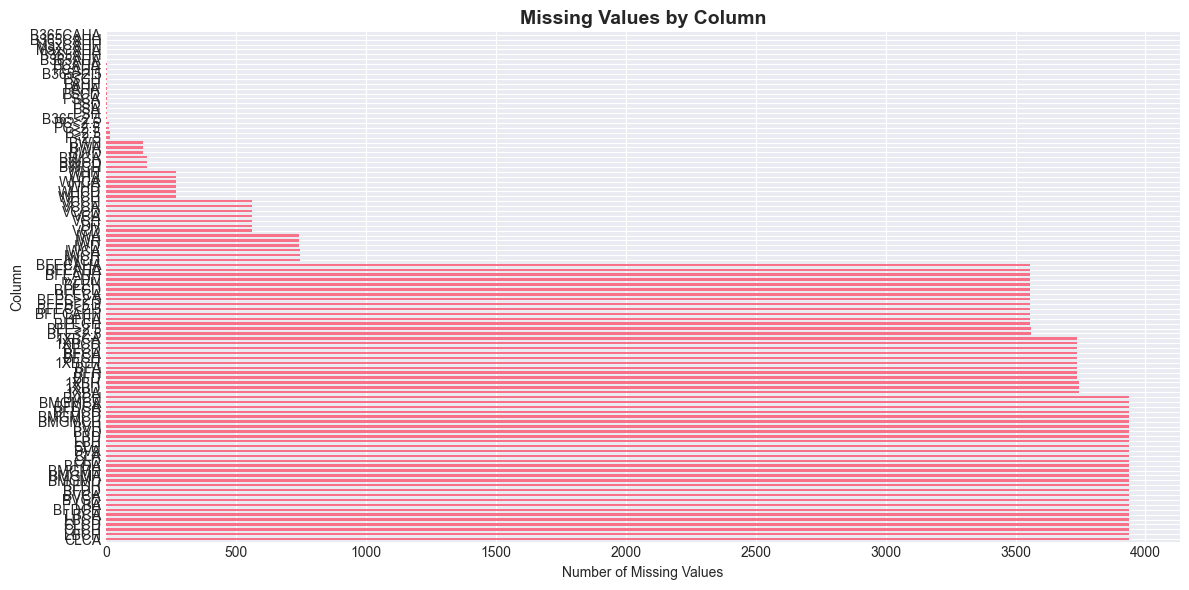

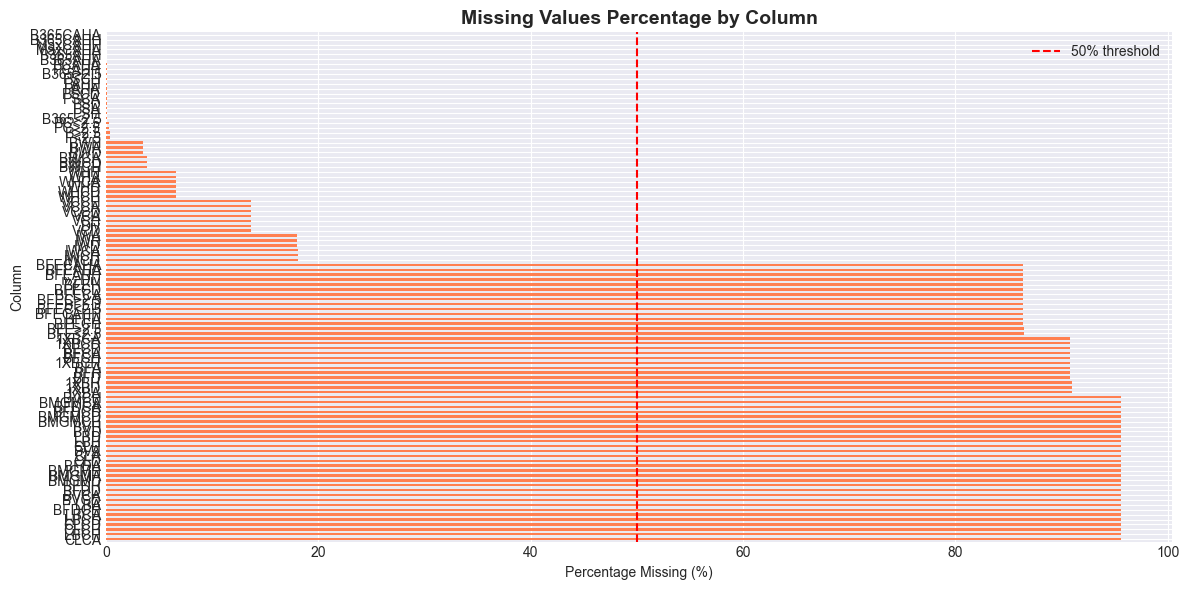

In [17]:
# Visualize missing values
if df_all is not None:
    # Get columns with missing values
    missing_data = df_all.isnull().sum()
    missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
    
    if len(missing_data) > 0:
        plt.figure(figsize=(12, 6))
        missing_data.plot(kind='barh')
        plt.title('Missing Values by Column', fontsize=14, fontweight='bold')
        plt.xlabel('Number of Missing Values')
        plt.ylabel('Column')
        plt.tight_layout()
        plt.show()
        
        # Percentage missing
        missing_pct = (missing_data / len(df_all)) * 100
        plt.figure(figsize=(12, 6))
        missing_pct.plot(kind='barh', color='coral')
        plt.title('Missing Values Percentage by Column', fontsize=14, fontweight='bold')
        plt.xlabel('Percentage Missing (%)')
        plt.ylabel('Column')
        plt.axvline(x=50, color='r', linestyle='--', label='50% threshold')
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("✓ No missing values found!")


GOALS DISTRIBUTION ANALYSIS

Home Goals (FTHG):
count    4116.000000
mean        1.477405
std         1.283307
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         9.000000
Name: FTHG, dtype: float64

Away Goals (FTAG):
count    4116.000000
mean        1.241983
std         1.168541
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         9.000000
Name: FTAG, dtype: float64


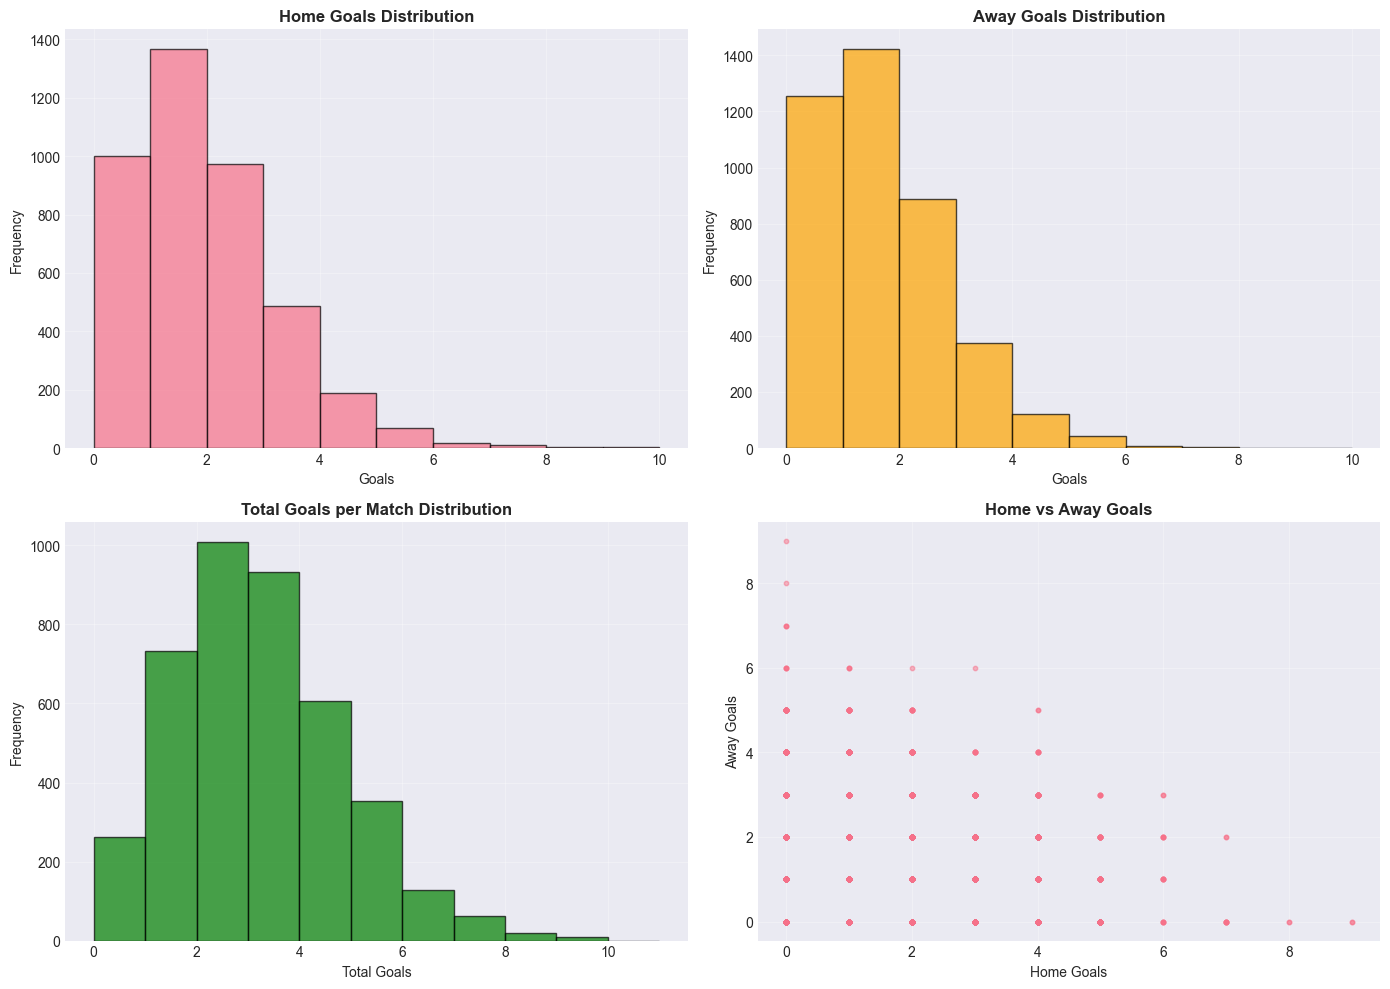


Match Results Distribution (FTR):
FTR
H    1782
A    1343
D     991
Name: count, dtype: int64


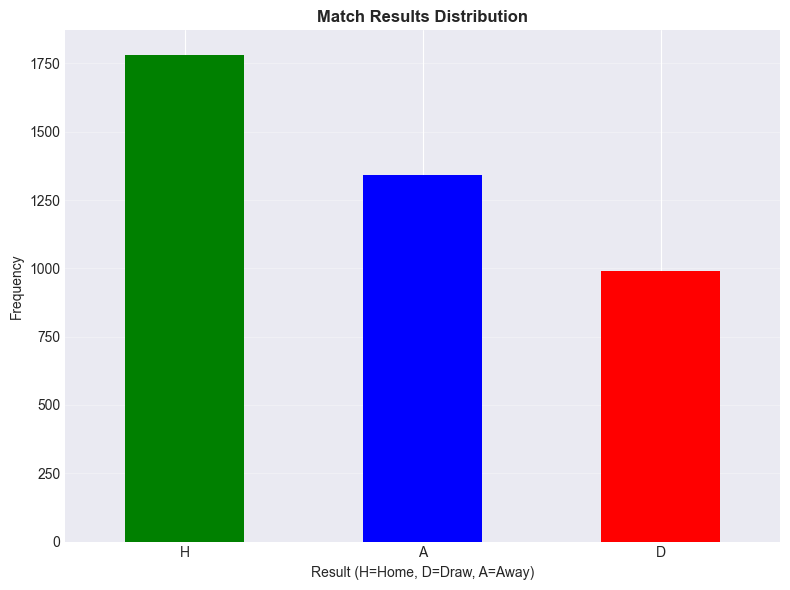

In [18]:
# Analyze goals distribution
if df_all is not None:
    # Find goal columns
    fthg_col = None
    ftag_col = None
    for col in df_all.columns:
        if 'fthg' in col.lower() and fthg_col is None:
            fthg_col = col
        if 'ftag' in col.lower() and ftag_col is None:
            ftag_col = col
    
    if fthg_col and ftag_col:
        print("=" * 80)
        print("GOALS DISTRIBUTION ANALYSIS")
        print("=" * 80)
        
        # Basic statistics
        print(f"\nHome Goals ({fthg_col}):")
        print(df_all[fthg_col].describe())
        print(f"\nAway Goals ({ftag_col}):")
        print(df_all[ftag_col].describe())
        
        # Visualizations
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # Home goals distribution
        axes[0, 0].hist(df_all[fthg_col].dropna(), bins=range(0, 11), edgecolor='black', alpha=0.7)
        axes[0, 0].set_title('Home Goals Distribution', fontweight='bold')
        axes[0, 0].set_xlabel('Goals')
        axes[0, 0].set_ylabel('Frequency')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Away goals distribution
        axes[0, 1].hist(df_all[ftag_col].dropna(), bins=range(0, 11), edgecolor='black', alpha=0.7, color='orange')
        axes[0, 1].set_title('Away Goals Distribution', fontweight='bold')
        axes[0, 1].set_xlabel('Goals')
        axes[0, 1].set_ylabel('Frequency')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Combined goals
        total_goals = df_all[fthg_col] + df_all[ftag_col]
        axes[1, 0].hist(total_goals.dropna(), bins=range(0, 12), edgecolor='black', alpha=0.7, color='green')
        axes[1, 0].set_title('Total Goals per Match Distribution', fontweight='bold')
        axes[1, 0].set_xlabel('Total Goals')
        axes[1, 0].set_ylabel('Frequency')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Goals scatter plot
        axes[1, 1].scatter(df_all[fthg_col], df_all[ftag_col], alpha=0.5, s=10)
        axes[1, 1].set_title('Home vs Away Goals', fontweight='bold')
        axes[1, 1].set_xlabel('Home Goals')
        axes[1, 1].set_ylabel('Away Goals')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Match results distribution
        if 'FTR' in df_all.columns or any('ftr' in c.lower() for c in df_all.columns):
            ftr_col = [c for c in df_all.columns if 'ftr' in c.lower()][0] if any('ftr' in c.lower() for c in df_all.columns) else None
            if ftr_col:
                result_counts = df_all[ftr_col].value_counts()
                print(f"\nMatch Results Distribution ({ftr_col}):")
                print(result_counts)
                
                plt.figure(figsize=(8, 6))
                result_counts.plot(kind='bar', color=['green', 'blue', 'red'])
                plt.title('Match Results Distribution', fontweight='bold')
                plt.xlabel('Result (H=Home, D=Draw, A=Away)')
                plt.ylabel('Frequency')
                plt.xticks(rotation=0)
                plt.grid(True, alpha=0.3, axis='y')
                plt.tight_layout()
                plt.show()


ODDS DISTRIBUTION ANALYSIS


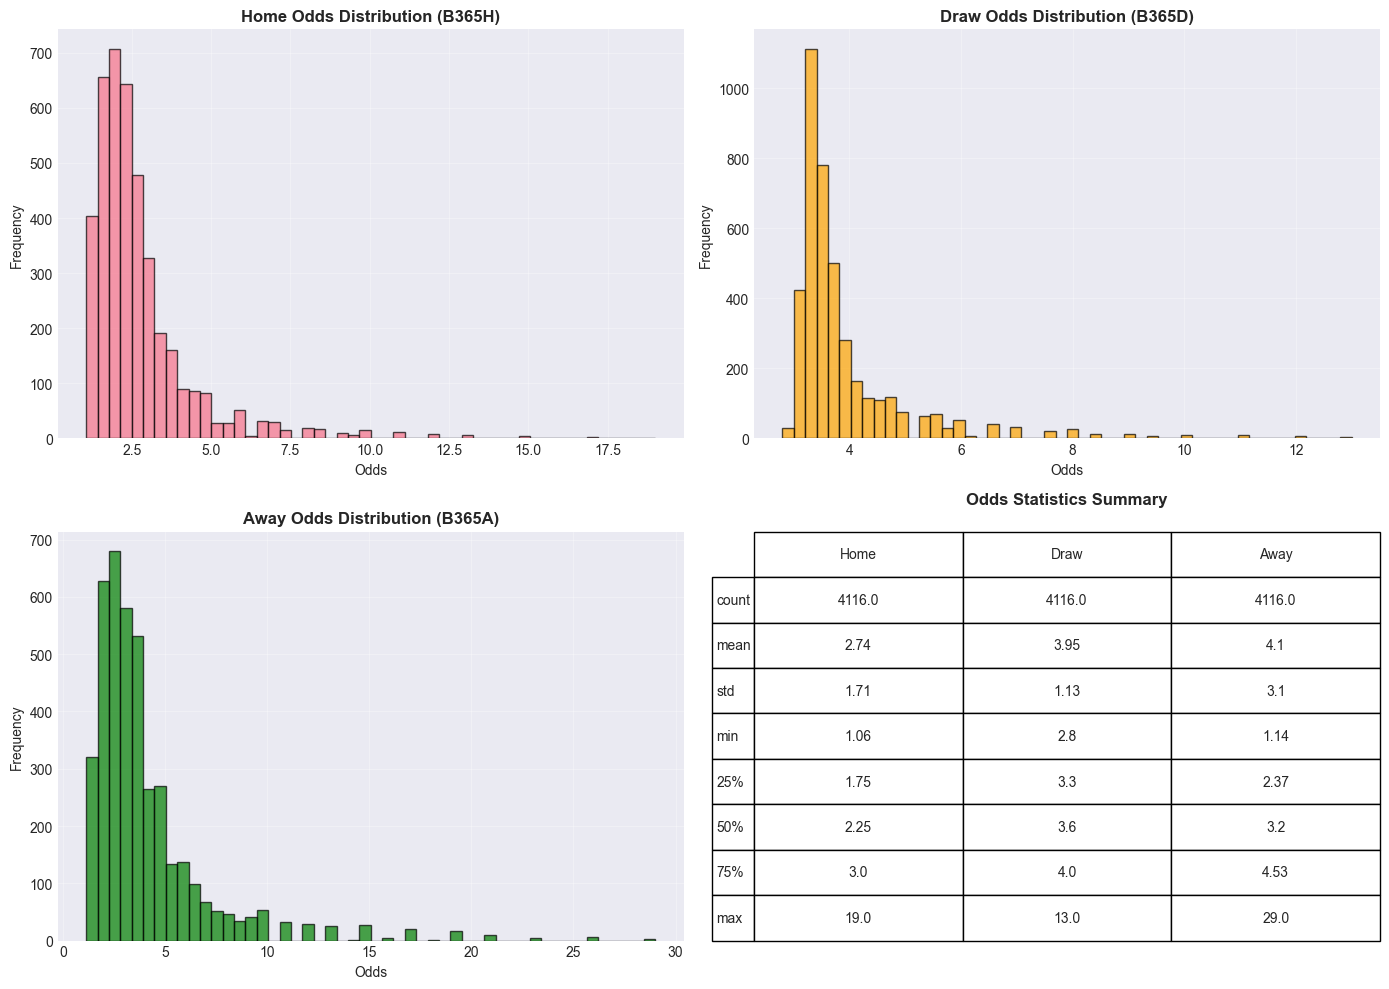


Invalid Odds Found:
  Home: 0 rows
  Draw: 0 rows
  Away: 0 rows

Overround Statistics:
  Mean: 0.0538
  Min: 0.0201
  Max: 0.1667


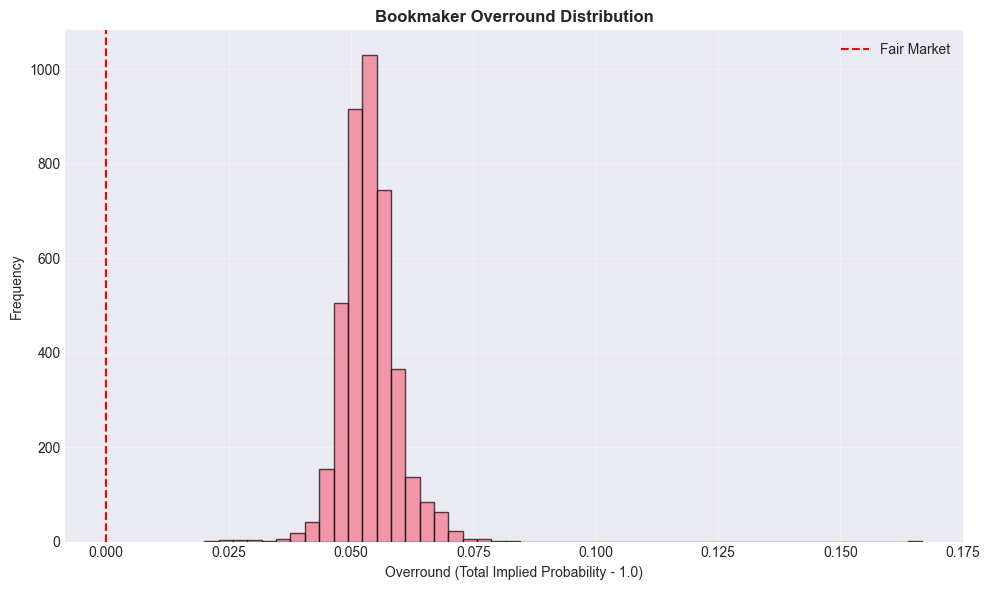

In [19]:
# Analyze odds distribution
if df_all is not None:
    # Find odds columns
    odds_cols = [col for col in df_all.columns if 'b365' in col.lower() or ('avg' in col.lower() and any(x in col.lower() for x in ['h', 'd', 'a']))]
    
    if len(odds_cols) >= 3:
        print("=" * 80)
        print("ODDS DISTRIBUTION ANALYSIS")
        print("=" * 80)
        
        # Identify home, draw, away odds
        home_odds_col = [c for c in odds_cols if 'h' in c.lower()][0] if any('h' in c.lower() for c in odds_cols) else None
        draw_odds_col = [c for c in odds_cols if 'd' in c.lower()][0] if any('d' in c.lower() for c in odds_cols) else None
        away_odds_col = [c for c in odds_cols if 'a' in c.lower()][0] if any('a' in c.lower() for c in odds_cols) else None
        
        if home_odds_col and draw_odds_col and away_odds_col:
            fig, axes = plt.subplots(2, 2, figsize=(14, 10))
            
            # Home odds
            axes[0, 0].hist(df_all[home_odds_col].dropna(), bins=50, edgecolor='black', alpha=0.7)
            axes[0, 0].set_title(f'Home Odds Distribution ({home_odds_col})', fontweight='bold')
            axes[0, 0].set_xlabel('Odds')
            axes[0, 0].set_ylabel('Frequency')
            axes[0, 0].grid(True, alpha=0.3)
            
            # Draw odds
            axes[0, 1].hist(df_all[draw_odds_col].dropna(), bins=50, edgecolor='black', alpha=0.7, color='orange')
            axes[0, 1].set_title(f'Draw Odds Distribution ({draw_odds_col})', fontweight='bold')
            axes[0, 1].set_xlabel('Odds')
            axes[0, 1].set_ylabel('Frequency')
            axes[0, 1].grid(True, alpha=0.3)
            
            # Away odds
            axes[1, 0].hist(df_all[away_odds_col].dropna(), bins=50, edgecolor='black', alpha=0.7, color='green')
            axes[1, 0].set_title(f'Away Odds Distribution ({away_odds_col})', fontweight='bold')
            axes[1, 0].set_xlabel('Odds')
            axes[1, 0].set_ylabel('Frequency')
            axes[1, 0].grid(True, alpha=0.3)
            
            # Odds statistics
            odds_stats = pd.DataFrame({
                'Home': df_all[home_odds_col].describe(),
                'Draw': df_all[draw_odds_col].describe(),
                'Away': df_all[away_odds_col].describe()
            })
            axes[1, 1].axis('off')
            axes[1, 1].table(cellText=odds_stats.values.round(2),
                            rowLabels=odds_stats.index,
                            colLabels=odds_stats.columns,
                            cellLoc='center',
                            loc='center',
                            bbox=[0, 0, 1, 1])
            axes[1, 1].set_title('Odds Statistics Summary', fontweight='bold', pad=20)
            
            plt.tight_layout()
            plt.show()
            
            # Check for invalid odds
            invalid_home = df_all[(df_all[home_odds_col] < 1.0) | (df_all[home_odds_col] > 100.0)]
            invalid_draw = df_all[(df_all[draw_odds_col] < 1.0) | (df_all[draw_odds_col] > 100.0)]
            invalid_away = df_all[(df_all[away_odds_col] < 1.0) | (df_all[away_odds_col] > 100.0)]
            
            print(f"\nInvalid Odds Found:")
            print(f"  Home: {len(invalid_home)} rows")
            print(f"  Draw: {len(invalid_draw)} rows")
            print(f"  Away: {len(invalid_away)} rows")
            
            # Market probabilities
            if len(invalid_home) == 0 and len(invalid_draw) == 0 and len(invalid_away) == 0:
                df_all['implied_prob_home'] = 1 / df_all[home_odds_col]
                df_all['implied_prob_draw'] = 1 / df_all[draw_odds_col]
                df_all['implied_prob_away'] = 1 / df_all[away_odds_col]
                df_all['total_implied_prob'] = df_all['implied_prob_home'] + df_all['implied_prob_draw'] + df_all['implied_prob_away']
                
                # Check for overround
                overround = df_all['total_implied_prob'] - 1.0
                print(f"\nOverround Statistics:")
                print(f"  Mean: {overround.mean():.4f}")
                print(f"  Min: {overround.min():.4f}")
                print(f"  Max: {overround.max():.4f}")
                
                plt.figure(figsize=(10, 6))
                plt.hist(overround.dropna(), bins=50, edgecolor='black', alpha=0.7)
                plt.title('Bookmaker Overround Distribution', fontweight='bold')
                plt.xlabel('Overround (Total Implied Probability - 1.0)')
                plt.ylabel('Frequency')
                plt.axvline(x=0, color='r', linestyle='--', label='Fair Market')
                plt.legend()
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()


DATA BY LEAGUE AND SEASON

Matches by League:
league_code
E0    2460
E1    1656
Name: count, dtype: int64


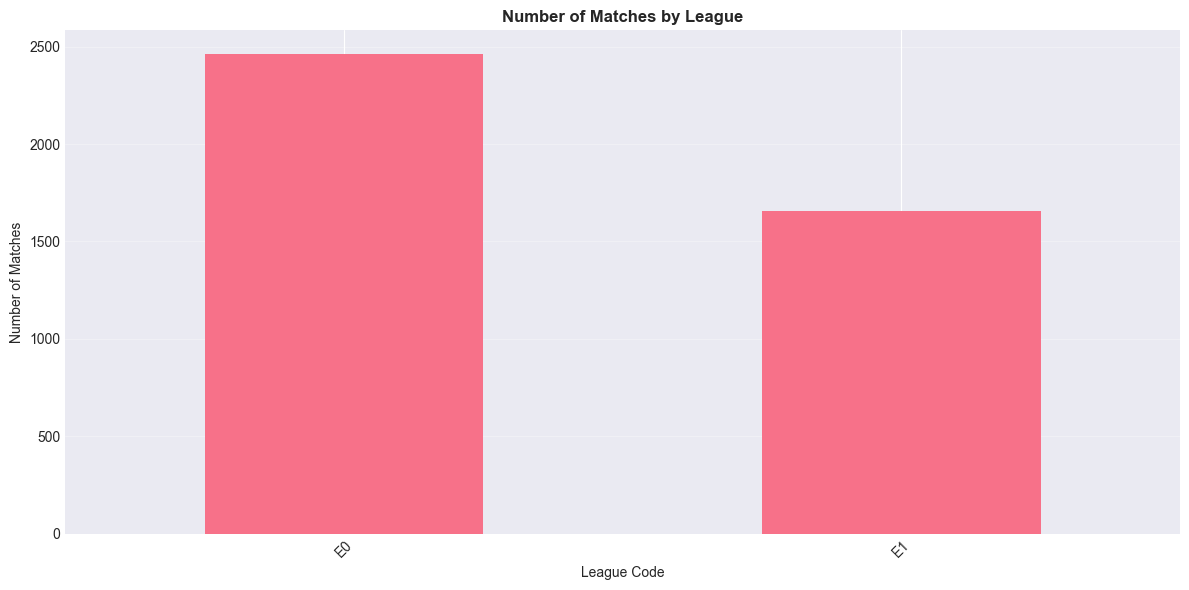


Matches by Season:
season
1920    932
2021    932
2122    932
2223    380
2324    380
2425    380
2526    180
Name: count, dtype: int64


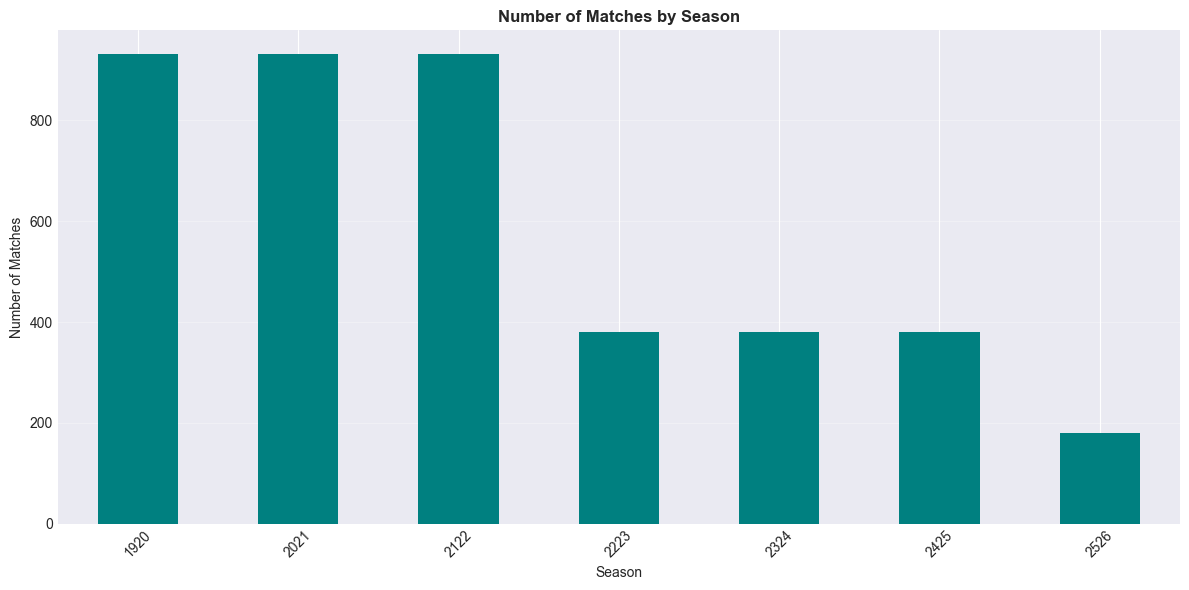


Matches by Batch Folder:
batch_folder
batch_176_Premier_League    2460
batch_177_Championship      1656
Name: count, dtype: int64


In [20]:
# Analyze by league and season
if df_all is not None and 'league_code' in df_all.columns:
    print("=" * 80)
    print("DATA BY LEAGUE AND SEASON")
    print("=" * 80)
    
    # Count by league
    if 'league_code' in df_all.columns:
        league_counts = df_all['league_code'].value_counts()
        print(f"\nMatches by League:")
        print(league_counts)
        
        plt.figure(figsize=(12, 6))
        league_counts.plot(kind='bar')
        plt.title('Number of Matches by League', fontweight='bold')
        plt.xlabel('League Code')
        plt.ylabel('Number of Matches')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
    
    # Count by season
    if 'season' in df_all.columns:
        season_counts = df_all['season'].value_counts().sort_index()
        print(f"\nMatches by Season:")
        print(season_counts)
        
        plt.figure(figsize=(12, 6))
        season_counts.plot(kind='bar', color='teal')
        plt.title('Number of Matches by Season', fontweight='bold')
        plt.xlabel('Season')
        plt.ylabel('Number of Matches')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3, axis='y')
        plt.tight_layout()
        plt.show()
    
    # Count by batch
    if 'batch_folder' in df_all.columns:
        batch_counts = df_all['batch_folder'].value_counts()
        print(f"\nMatches by Batch Folder:")
        print(batch_counts.head(10))


## 4. Data Cleaning Methods Identification


In [21]:
# Identify data cleaning methods needed
def identify_cleaning_methods(df, quality_report):
    """Identify required data cleaning methods"""
    cleaning_methods = {
        'missing_values': [],
        'outliers': [],
        'data_type_conversions': [],
        'duplicates': [],
        'invalid_values': [],
        'normalization': [],
        'feature_engineering': []
    }
    
    # 1. Missing Values Handling
    missing_data = df.isnull().sum()
    high_missing = missing_data[missing_data > len(df) * 0.5]  # >50% missing
    medium_missing = missing_data[(missing_data > len(df) * 0.1) & (missing_data <= len(df) * 0.5)]  # 10-50% missing
    low_missing = missing_data[(missing_data > 0) & (missing_data <= len(df) * 0.1)]  # <10% missing
    
    if len(high_missing) > 0:
        cleaning_methods['missing_values'].append({
            'method': 'drop_columns',
            'columns': high_missing.index.tolist(),
            'reason': 'More than 50% missing values',
            'priority': 'high'
        })
    
    if len(medium_missing) > 0:
        cleaning_methods['missing_values'].append({
            'method': 'impute_or_drop',
            'columns': medium_missing.index.tolist(),
            'reason': '10-50% missing values - consider imputation or dropping',
            'priority': 'medium'
        })
    
    if len(low_missing) > 0:
        cleaning_methods['missing_values'].append({
            'method': 'impute',
            'columns': low_missing.index.tolist(),
            'reason': 'Less than 10% missing - safe to impute',
            'priority': 'low',
            'suggestions': ['mean', 'median', 'mode', 'forward_fill']
        })
    
    # 2. Duplicate Handling
    if quality_report['duplicate_rows'] > 0:
        cleaning_methods['duplicates'].append({
            'method': 'remove_duplicates',
            'count': quality_report['duplicate_rows'],
            'reason': 'Duplicate rows found',
            'priority': 'high'
        })
    
    # 3. Data Type Conversions
    date_cols = [col for col in df.columns if 'date' in col.lower()]
    for col in date_cols:
        if df[col].dtype == 'object':
            cleaning_methods['data_type_conversions'].append({
                'method': 'convert_to_datetime',
                'column': col,
                'reason': 'Date column stored as string',
                'priority': 'high'
            })
    
    # 4. Invalid Values
    for issue in quality_report['issues']:
        if issue['type'] == 'invalid_goals':
            cleaning_methods['invalid_values'].append({
                'method': 'remove_or_cap',
                'column': issue['column'],
                'reason': 'Goals outside valid range (0-20)',
                'priority': 'high',
                'suggestion': 'Remove rows or cap at reasonable maximum'
            })
        elif issue['type'] == 'invalid_odds':
            cleaning_methods['invalid_values'].append({
                'method': 'remove_or_cap',
                'column': issue['column'],
                'reason': 'Odds outside valid range (1.0-100.0)',
                'priority': 'high',
                'suggestion': 'Remove rows with invalid odds'
            })
    
    # 5. Outlier Detection
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols[:10]:  # Check first 10 numeric columns
        if col in df.columns:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
            if len(outliers) > 0:
                cleaning_methods['outliers'].append({
                    'method': 'detect_outliers',
                    'column': col,
                    'count': len(outliers),
                    'percentage': (len(outliers) / len(df)) * 100,
                    'reason': f'Outliers detected (IQR method)',
                    'priority': 'medium'
                })
    
    # 6. Feature Engineering Opportunities
    if 'FTHG' in df.columns or any('fthg' in c.lower() for c in df.columns):
        fthg_col = [c for c in df.columns if 'fthg' in c.lower()][0]
        ftag_col = [c for c in df.columns if 'ftag' in c.lower()][0] if any('ftag' in c.lower() for c in df.columns) else None
        if ftag_col:
            cleaning_methods['feature_engineering'].append({
                'method': 'create_total_goals',
                'formula': f'{fthg_col} + {ftag_col}',
                'reason': 'Total goals per match',
                'priority': 'low'
            })
            cleaning_methods['feature_engineering'].append({
                'method': 'create_goal_difference',
                'formula': f'{fthg_col} - {ftag_col}',
                'reason': 'Goal difference (home - away)',
                'priority': 'low'
            })
    
    return cleaning_methods

if df_all is not None:
    cleaning_methods = identify_cleaning_methods(df_all, quality_report)
    
    print("=" * 80)
    print("DATA CLEANING METHODS IDENTIFIED")
    print("=" * 80)
    
    for category, methods in cleaning_methods.items():
        if methods:
            print(f"\n{'='*80}")
            print(f"{category.upper().replace('_', ' ')}")
            print(f"{'='*80}")
            for i, method in enumerate(methods, 1):
                print(f"\n{i}. {method['method'].upper()}")
                print(f"   Priority: {method.get('priority', 'N/A').upper()}")
                if 'columns' in method:
                    print(f"   Columns: {', '.join(method['columns'][:5])}{'...' if len(method['columns']) > 5 else ''}")
                elif 'column' in method:
                    print(f"   Column: {method['column']}")
                if 'count' in method:
                    print(f"   Count: {method['count']:,}")
                if 'percentage' in method:
                    print(f"   Percentage: {method['percentage']:.2f}%")
                print(f"   Reason: {method['reason']}")
                if 'suggestions' in method:
                    print(f"   Suggestions: {', '.join(method['suggestions'])}")
                if 'suggestion' in method:
                    print(f"   Suggestion: {method['suggestion']}")
                if 'formula' in method:
                    print(f"   Formula: {method['formula']}")


DATA CLEANING METHODS IDENTIFIED

MISSING VALUES

1. DROP_COLUMNS
   Priority: HIGH
   Columns: ï»¿Div, BFH, BFD, BFA, 1XBH...
   Reason: More than 50% missing values

2. IMPUTE_OR_DROP
   Priority: MEDIUM
   Columns: Div, IWH, IWD, IWA, VCH...
   Reason: 10-50% missing values - consider imputation or dropping

3. IMPUTE
   Priority: LOW
   Columns: BWH, BWD, BWA, PSH, PSD...
   Reason: Less than 10% missing - safe to impute
   Suggestions: mean, median, mode, forward_fill

OUTLIERS

1. DETECT_OUTLIERS
   Priority: MEDIUM
   Column: FTHG
   Count: 288
   Percentage: 7.00%
   Reason: Outliers detected (IQR method)

2. DETECT_OUTLIERS
   Priority: MEDIUM
   Column: FTAG
   Count: 14
   Percentage: 0.34%
   Reason: Outliers detected (IQR method)

3. DETECT_OUTLIERS
   Priority: MEDIUM
   Column: HTHG
   Count: 138
   Percentage: 3.35%
   Reason: Outliers detected (IQR method)

4. DETECT_OUTLIERS
   Priority: MEDIUM
   Column: HTAG
   Count: 82
   Percentage: 1.99%
   Reason: Outliers dete

In [22]:
# Generate cleaning recommendations summary
if df_all is not None:
    print("\n" + "=" * 80)
    print("CLEANING RECOMMENDATIONS SUMMARY")
    print("=" * 80)
    
    total_issues = sum(len(methods) for methods in cleaning_methods.values())
    high_priority = [m for methods in cleaning_methods.values() for m in methods if m.get('priority') == 'high']
    medium_priority = [m for methods in cleaning_methods.values() for m in methods if m.get('priority') == 'medium']
    low_priority = [m for methods in cleaning_methods.values() for m in methods if m.get('priority') == 'low']
    
    print(f"\nTotal Issues Found: {total_issues}")
    print(f"  🔴 High Priority: {len(high_priority)}")
    print(f"  🟡 Medium Priority: {len(medium_priority)}")
    print(f"  🟢 Low Priority: {len(low_priority)}")
    
    if high_priority:
        print(f"\n🔴 HIGH PRIORITY ACTIONS:")
        for i, method in enumerate(high_priority, 1):
            print(f"   {i}. {method['method']} - {method['reason']}")
    
    if medium_priority:
        print(f"\n🟡 MEDIUM PRIORITY ACTIONS:")
        for i, method in enumerate(medium_priority[:5], 1):  # Show first 5
            print(f"   {i}. {method['method']} - {method['reason']}")
    
    # Create cleaning pipeline code template
    print(f"\n" + "=" * 80)
    print("SUGGESTED CLEANING PIPELINE CODE")
    print("=" * 80)
    
    pipeline_code = """
# Data Cleaning Pipeline
def clean_football_data(df):
    \"\"\"Apply cleaning methods to football data\"\"\"
    df_clean = df.copy()
    
    # 1. Remove duplicate rows
"""
    
    if quality_report['duplicate_rows'] > 0:
        pipeline_code += f"    df_clean = df_clean.drop_duplicates()  # Removed {quality_report['duplicate_rows']} duplicates\n"
    
    pipeline_code += "\n    # 2. Handle missing values\n"
    
    if cleaning_methods['missing_values']:
        for method in cleaning_methods['missing_values']:
            if method['method'] == 'drop_columns':
                cols = method['columns'][:3]  # Show first 3
                pipeline_code += f"    # Drop columns with >50% missing: {', '.join(cols)}\n"
                pipeline_code += f"    # df_clean = df_clean.drop(columns={method['columns']})\n"
            elif method['method'] == 'impute':
                cols = method['columns'][:3]
                pipeline_code += f"    # Impute missing values in: {', '.join(cols)}\n"
                pipeline_code += f"    # df_clean['column'] = df_clean['column'].fillna(df_clean['column'].median())\n"
    
    pipeline_code += "\n    # 3. Remove invalid values\n"
    
    if cleaning_methods['invalid_values']:
        for method in cleaning_methods['invalid_values']:
            pipeline_code += f"    # Remove invalid {method['column']}: {method['reason']}\n"
            pipeline_code += f"    # df_clean = df_clean[(df_clean['{method['column']}'] >= min_val) & (df_clean['{method['column']}'] <= max_val)]\n"
    
    pipeline_code += "\n    # 4. Convert data types\n"
    pipeline_code += "    # Convert date columns to datetime\n"
    pipeline_code += "    # df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%d/%m/%Y', errors='coerce')\n"
    
    pipeline_code += "\n    return df_clean\n"
    
    print(pipeline_code)



CLEANING RECOMMENDATIONS SUMMARY

Total Issues Found: 16
  🔴 High Priority: 2
  🟡 Medium Priority: 11
  🟢 Low Priority: 3

🔴 HIGH PRIORITY ACTIONS:
   1. drop_columns - More than 50% missing values
   2. convert_to_datetime - Date column stored as string

🟡 MEDIUM PRIORITY ACTIONS:
   1. impute_or_drop - 10-50% missing values - consider imputation or dropping
   2. detect_outliers - Outliers detected (IQR method)
   3. detect_outliers - Outliers detected (IQR method)
   4. detect_outliers - Outliers detected (IQR method)
   5. detect_outliers - Outliers detected (IQR method)

SUGGESTED CLEANING PIPELINE CODE

# Data Cleaning Pipeline
def clean_football_data(df):
    """Apply cleaning methods to football data"""
    df_clean = df.copy()

    # 1. Remove duplicate rows

    # 2. Handle missing values
    # Drop columns with >50% missing: ï»¿Div, BFH, BFD
    # df_clean = df_clean.drop(columns=['ï»¿Div', 'BFH', 'BFD', 'BFA', '1XBH', '1XBD', '1XBA', 'BFEH', 'BFED', 'BFEA', 'BFE>2.5', 'BFE

## 5. Available Data Cleaning Methods

Based on the analysis above, here are the available cleaning methods:


In [23]:
# Display available cleaning methods
cleaning_methods_available = {
    'Missing Values': {
        'drop_columns': 'Remove columns with >50% missing values',
        'impute_mean': 'Fill missing numeric values with mean',
        'impute_median': 'Fill missing numeric values with median',
        'impute_mode': 'Fill missing categorical values with mode',
        'forward_fill': 'Forward fill (for time series data)',
        'backward_fill': 'Backward fill (for time series data)',
        'interpolate': 'Interpolate missing values',
        'drop_rows': 'Remove rows with missing critical columns'
    },
    'Outliers': {
        'iqr_method': 'Remove outliers using IQR (Q1-1.5*IQR to Q3+1.5*IQR)',
        'z_score': 'Remove outliers using Z-score (>3 standard deviations)',
        'cap_values': 'Cap outliers at reasonable min/max values',
        'winsorize': 'Winsorize outliers (replace with percentile values)'
    },
    'Data Type Conversions': {
        'to_datetime': 'Convert date strings to datetime objects',
        'to_numeric': 'Convert numeric strings to numeric types',
        'to_category': 'Convert string columns to categorical (memory efficient)',
        'to_int': 'Convert float columns to integer where appropriate'
    },
    'Invalid Values': {
        'remove_invalid_goals': 'Remove rows with goals < 0 or > 20',
        'remove_invalid_odds': 'Remove rows with odds < 1.0 or > 100.0',
        'remove_invalid_dates': 'Remove rows with invalid or future dates',
        'remove_empty_teams': 'Remove rows with missing team names'
    },
    'Duplicates': {
        'remove_duplicates': 'Remove exact duplicate rows',
        'remove_duplicate_matches': 'Remove duplicate matches (same teams, same date)',
        'keep_first': 'Keep first occurrence of duplicates',
        'keep_last': 'Keep last occurrence of duplicates'
    },
    'Normalization': {
        'standardize_team_names': 'Normalize team name variations',
        'standardize_league_codes': 'Normalize league code formats',
        'normalize_dates': 'Standardize date formats'
    },
    'Feature Engineering': {
        'create_total_goals': 'Calculate total goals per match',
        'create_goal_difference': 'Calculate goal difference',
        'create_result': 'Derive match result (H/D/A) from goals',
        'create_implied_probabilities': 'Calculate probabilities from odds',
        'create_overround': 'Calculate bookmaker overround'
    }
}

print("=" * 80)
print("AVAILABLE DATA CLEANING METHODS")
print("=" * 80)

for category, methods in cleaning_methods_available.items():
    print(f"\n{category}:")
    print("-" * 80)
    for method, description in methods.items():
        print(f"  • {method}: {description}")

# Save to JSON for reference
methods_json = json.dumps(cleaning_methods_available, indent=2)
with open('available_cleaning_methods.json', 'w') as f:
    f.write(methods_json)
print(f"\n✓ Saved available cleaning methods to 'available_cleaning_methods.json'")


AVAILABLE DATA CLEANING METHODS

Missing Values:
--------------------------------------------------------------------------------
  • drop_columns: Remove columns with >50% missing values
  • impute_mean: Fill missing numeric values with mean
  • impute_median: Fill missing numeric values with median
  • impute_mode: Fill missing categorical values with mode
  • forward_fill: Forward fill (for time series data)
  • backward_fill: Backward fill (for time series data)
  • interpolate: Interpolate missing values
  • drop_rows: Remove rows with missing critical columns

Outliers:
--------------------------------------------------------------------------------
  • iqr_method: Remove outliers using IQR (Q1-1.5*IQR to Q3+1.5*IQR)
  • z_score: Remove outliers using Z-score (>3 standard deviations)
  • cap_values: Cap outliers at reasonable min/max values
  • winsorize: Winsorize outliers (replace with percentile values)

Data Type Conversions:
--------------------------------------------------

## 6. Data Quality Score

Calculate overall data quality score based on various metrics.


DATA QUALITY SCORE

Overall Quality Score: 83.9/100


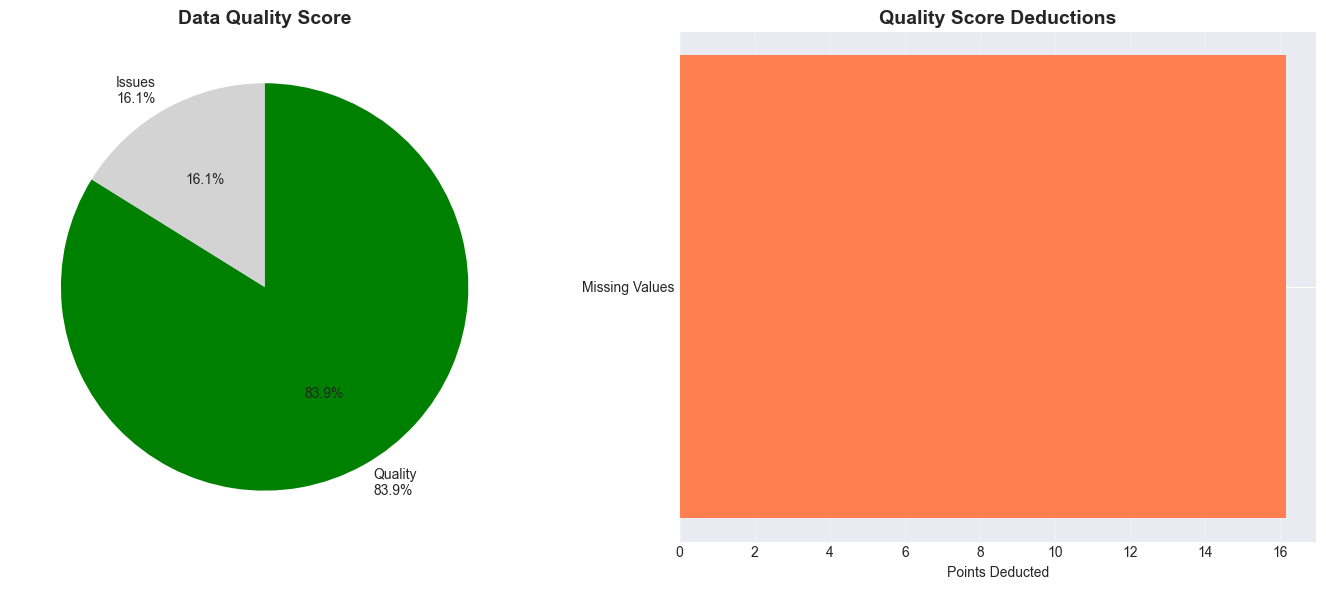


Quality Rating: Good

Breakdown:
  Missing Values: -16.1 points (32.29%)


In [24]:
# Calculate data quality score
def calculate_quality_score(df, quality_report):
    """Calculate overall data quality score (0-100)"""
    score = 100.0
    deductions = []
    
    # Deduct for missing values
    total_cells = df.shape[0] * df.shape[1]
    missing_cells = df.isnull().sum().sum()
    missing_pct = (missing_cells / total_cells) * 100
    missing_deduction = min(missing_pct * 0.5, 30)  # Max 30 points deduction
    score -= missing_deduction
    deductions.append(('Missing Values', missing_deduction, f'{missing_pct:.2f}%'))
    
    # Deduct for duplicates
    duplicate_pct = (quality_report['duplicate_rows'] / len(df)) * 100
    duplicate_deduction = min(duplicate_pct * 0.3, 20)  # Max 20 points deduction
    score -= duplicate_deduction
    deductions.append(('Duplicates', duplicate_deduction, f'{duplicate_pct:.2f}%'))
    
    # Deduct for invalid values
    invalid_count = sum(issue.get('count', 0) for issue in quality_report['issues'] if 'count' in issue)
    invalid_pct = (invalid_count / len(df)) * 100
    invalid_deduction = min(invalid_pct * 0.5, 25)  # Max 25 points deduction
    score -= invalid_deduction
    deductions.append(('Invalid Values', invalid_deduction, f'{invalid_pct:.2f}%'))
    
    # Ensure score is between 0 and 100
    score = max(0, min(100, score))
    
    return score, deductions

if df_all is not None:
    quality_score, deductions = calculate_quality_score(df_all, quality_report)
    
    print("=" * 80)
    print("DATA QUALITY SCORE")
    print("=" * 80)
    print(f"\nOverall Quality Score: {quality_score:.1f}/100")
    
    # Visualize score
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Score gauge
    ax1.pie([quality_score, 100-quality_score], 
            labels=[f'Quality\n{quality_score:.1f}%', f'Issues\n{100-quality_score:.1f}%'],
            colors=['green' if quality_score >= 80 else 'orange' if quality_score >= 60 else 'red', 'lightgray'],
            startangle=90,
            counterclock=False,
            autopct='%1.1f%%')
    ax1.set_title('Data Quality Score', fontweight='bold', fontsize=14)
    
    # Deductions breakdown
    if deductions:
        deduction_df = pd.DataFrame(deductions, columns=['Category', 'Points Lost', 'Percentage'])
        deduction_df = deduction_df[deduction_df['Points Lost'] > 0]
        if len(deduction_df) > 0:
            ax2.barh(deduction_df['Category'], deduction_df['Points Lost'], color='coral')
            ax2.set_title('Quality Score Deductions', fontweight='bold', fontsize=14)
            ax2.set_xlabel('Points Deducted')
            ax2.grid(True, alpha=0.3, axis='x')
        else:
            ax2.text(0.5, 0.5, 'No Deductions!', ha='center', va='center', fontsize=16, fontweight='bold')
            ax2.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Quality rating
    if quality_score >= 90:
        rating = "Excellent"
        color = "green"
    elif quality_score >= 75:
        rating = "Good"
        color = "blue"
    elif quality_score >= 60:
        rating = "Fair"
        color = "orange"
    else:
        rating = "Poor"
        color = "red"
    
    print(f"\nQuality Rating: {rating}")
    print(f"\nBreakdown:")
    for category, deduction, pct in deductions:
        if deduction > 0:
            print(f"  {category}: -{deduction:.1f} points ({pct})")


## 7. Export Summary Report

Generate a summary report of findings and recommendations.


In [25]:
# Generate summary report
if df_all is not None:
    report = {
        'timestamp': datetime.now().isoformat(),
        'data_summary': {
            'total_rows': len(df_all),
            'total_columns': len(df_all.columns),
            'files_analyzed': len(csv_files),
            'leagues': df_all['league_code'].nunique() if 'league_code' in df_all.columns else 0,
            'seasons': df_all['season'].nunique() if 'season' in df_all.columns else 0
        },
        'quality_score': quality_score,
        'quality_rating': rating,
        'issues_found': {
            'missing_values': len([m for m in cleaning_methods['missing_values']]),
            'duplicates': quality_report['duplicate_rows'],
            'invalid_values': len([m for m in cleaning_methods['invalid_values']]),
            'outliers': len([m for m in cleaning_methods['outliers']])
        },
        'cleaning_recommendations': {
            'high_priority': [m['method'] for methods in cleaning_methods.values() for m in methods if m.get('priority') == 'high'],
            'medium_priority': [m['method'] for methods in cleaning_methods.values() for m in methods if m.get('priority') == 'medium'],
            'low_priority': [m['method'] for methods in cleaning_methods.values() for m in methods if m.get('priority') == 'low']
        },
        'available_methods': cleaning_methods_available
    }
    
    # Save report
    report_filename = f'data_quality_report_{datetime.now().strftime("%Y%m%d_%H%M%S")}.json'
    with open(report_filename, 'w') as f:
        json.dump(report, f, indent=2, default=str)
    
    print("=" * 80)
    print("SUMMARY REPORT")
    print("=" * 80)
    print(f"\n✓ Report saved to: {report_filename}")
    print(f"\nData Summary:")
    print(f"  Total Rows: {report['data_summary']['total_rows']:,}")
    print(f"  Total Columns: {report['data_summary']['total_columns']}")
    print(f"  Files Analyzed: {report['data_summary']['files_analyzed']}")
    print(f"  Leagues: {report['data_summary']['leagues']}")
    print(f"  Seasons: {report['data_summary']['seasons']}")
    print(f"\nQuality Score: {report['quality_score']:.1f}/100 ({report['quality_rating']})")
    print(f"\nIssues Found:")
    for issue, count in report['issues_found'].items():
        print(f"  {issue.replace('_', ' ').title()}: {count}")
    print(f"\nCleaning Recommendations:")
    print(f"  High Priority: {len(report['cleaning_recommendations']['high_priority'])}")
    print(f"  Medium Priority: {len(report['cleaning_recommendations']['medium_priority'])}")
    print(f"  Low Priority: {len(report['cleaning_recommendations']['low_priority'])}")


SUMMARY REPORT

✓ Report saved to: data_quality_report_20251229_054343.json

Data Summary:
  Total Rows: 4,116
  Total Columns: 171
  Files Analyzed: 182
  Leagues: 2
  Seasons: 7

Quality Score: 83.9/100 (Good)

Issues Found:
  Missing Values: 3
  Duplicates: 0
  Invalid Values: 0
  Outliers: 10

Cleaning Recommendations:
  High Priority: 2
  Medium Priority: 11
  Low Priority: 3
